In [2]:
# Restart the session after running this cell (Run it once!)
!git clone https://github.com/sparisi/gym_gridworlds
!pip install -e ./gym_gridworlds

Cloning into 'gym_gridworlds'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 140 (delta 36), reused 51 (delta 24), pack-reused 69 (from 1)
Receiving objects: 100% (140/140), 74.35 KiB | 624.00 KiB/s, done.
Resolving deltas: 100% (66/66), done.
Obtaining file:///content/gym_gridworlds
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.9 MB/s eta 0:00:00
  Running setup.py develop for Gym-Gridworlds


# Register Envoronments in Gym

In [1]:
from gymnasium.envs.registration import register

register(
    id="Gym-Gridworlds/Straight-20-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=200,
    kwargs={
        "grid": "20_straight",
    },
)

register(
    id="Gym-Gridworlds/Empty-2x2-v0",
    entry_point="gym_gridworlds.gridworld:GridworldRandomStart",
    max_episode_steps=10,
    kwargs={
        "grid": "2x2_empty",
    },
)

register(
    id="Gym-Gridworlds/Empty-3x3-v0",
    entry_point="gym_gridworlds.gridworld:GridworldRandomStart",
    max_episode_steps=50,
    kwargs={
        "grid": "3x3_empty",
    },
)

register(
    id="Gym-Gridworlds/Empty-Loop-3x3-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x3_empty_loop",
    },
)

register(
    id="Gym-Gridworlds/Empty-10x10-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=100,
    kwargs={
        "grid": "10x10_empty",
    },
)

register(
    id="Gym-Gridworlds/Empty-Distract-6x6-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "6x6_distract",
    },
)

register(
    id="Gym-Gridworlds/Penalty-3x3-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x3_penalty",
    },
)

register(
    id="Gym-Gridworlds/Quicksand-4x4-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "4x4_quicksand",
    },
)

register(
    id="Gym-Gridworlds/Quicksand-Distract-4x4-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "4x4_quicksand_distract",
    },
)

register(
    id="Gym-Gridworlds/TwoRoom-Quicksand-3x5-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x5_two_room_quicksand",
    },
)

register(
    id="Gym-Gridworlds/Corridor-3x4-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "3x4_corridor",
    },
)
register(
    id="Gym-Gridworlds/Full-4x5-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "4x5_full",
    },
)

register(
    id="Gym-Gridworlds/TwoRoom-Distract-Middle-2x11-v0",
    entry_point="gym_gridworlds.gridworld:GridworldMiddleStart",
    max_episode_steps=200,
    kwargs={
        "grid": "2x11_two_room_distract",
    },
)

register(
    id="Gym-Gridworlds/Barrier-5x5-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=50,
    kwargs={
        "grid": "5x5_barrier",
    },
)

register(
    id="Gym-Gridworlds/RiverSwim-6-v0",
    entry_point="gym_gridworlds.gridworld:RiverSwim",
    max_episode_steps=200,
    kwargs={
        "grid": "river_swim_6",
    },
)

register(
    id="Gym-Gridworlds/CliffWalk-4x12-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=200,
    kwargs={
        "grid": "4x12_cliffwalk",
    },
)

register(
    id="Gym-Gridworlds/DangerMaze-6x6-v0",
    entry_point="gym_gridworlds.gridworld:Gridworld",
    max_episode_steps=200,
    kwargs={
        "grid": "6x6_danger_maze",
    },
)

# Import Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import gym
import gymnasium

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Feature Functions

In [130]:
def rbf_features(
    state,
    centers,
    sigmas: float,
):
    state = torch.tensor(state, device=device)
    centers = torch.tensor(centers, device=device)
    D = centers.shape[0]
    N = state.shape[0]
    new_state = state[:, None, :].repeat(1, D, 1)
    new_center = centers.repeat(N, 1, 1)
    return torch.exp(-torch.linalg.norm(new_state - new_center, 2, axis=2)**2 / sigmas**2 / 2)


def tile_features(
    state: np.array,  # (N, S)
    centers: np.array,  # (D, S)
    widths: float,
    offsets: list = [0],  # list of tuples of length S
) -> np.array:  # (N, D)

    D = np.shape(centers)[0]
    N = np.shape(state)[0]
    new_state = np.repeat(state[:, None, :], D, axis=1)
    output = np.zeros((N, D))
    for offset in offsets:
        shifted_center = centers + offset
        new_center = np.repeat(shifted_center[None, :, :], N, axis=0)
        output += np.array(np.linalg.norm(new_state - new_center, np.inf, axis=2) < widths, dtype=np.float32)

    return output / len(offsets)


def coarse_features(
    state: np.array,  # (N, S)
    centers: np.array,  # (D, S)
    widths: float,
    offsets: list = [0],  # list of tuples of length S
) -> np.array:  # (N, D)

    D = np.shape(centers)[0]
    N = np.shape(state)[0]
    new_state = np.repeat(state[:, None, :], D, axis=1)
    output = np.zeros((N, D))
    for offset in offsets:
        shifted_center = centers + offset
        new_center = np.repeat(shifted_center[None, :, :], N, axis=0)
        output += np.array(np.linalg.norm(new_state - new_center, 2, axis=2) < widths, dtype=np.float32)

    return output / len(offsets)

def aggregation_features(state, centers):
    state = torch.tensor(state, device=device)
    centers = torch.tensor(centers, device=device)

    distance = torch.sum((state[:, None, :] - centers[None, :, :])**2, dim=-1)
    return (distance == distance.min(-1, keepdims=True).values) * 1.0  # make it float


In [5]:
s = np.array([[1, 2]])
c = np.array([[0, 0], [1, 1], [4, 4], [6, 6]])
aggregation_features(s, c)

tensor([[0., 1., 0., 0.]], device='cuda:0')

# Network

In [142]:
# Define the neural network model
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.feature_size = self.feature_extract_init(state_size, action_size)
        self.fc1 = nn.Linear(self.feature_size, fc1_units)
        self.init_weights(self.fc1)
        self.fc2 = nn.Linear(fc1_units, action_size)
        self.init_weights(self.fc2)

    def init_weights(self, layer):
        nn.init.xavier_normal(layer.weight)
        self.to(device)

    def feature_extract_init(self, state_size, action_size):
        n_centers = [3, 3]
        centers = np.array(
          np.meshgrid(*[
              np.linspace(env.observation_space.low[i], env.observation_space.high[i], n_centers[i])
              for i in range(env.observation_space.shape[0])
          ])
        ).reshape(env.observation_space.shape[0], -1).T
        centers = torch.tensor(centers).float().to(device)
        #self.feature_name, self.feature_extract = "Aggregate", lambda state : aggregation_features(state.reshape(-1, state_size), centers)
        self.feature_name, self.feature_extract = "RBF", lambda state : rbf_features(state.reshape(-1, state_size), centers, 0.2)
        return self.feature_extract(env.reset()[0]).shape[1]

    def forward(self, state):
        #x = F.relu(self.fc1(state))
        #x = F.relu(self.fc2(x))
        #return self.fc3(x)
        x = self.feature_extract(state)
        return self.fc2(self.fc1(x))

# ReplayBuffer

In [77]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

# DQN

In [86]:
# Define the DQN agent class
class DQNAgent:
    # Initialize the DQN agent
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > 64:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    # Choose an action based on the current state
    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)

    # Learn from batch of experiences
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = zip(*experiences)
        states = torch.from_numpy(np.vstack(states)).float().to(device)
        actions = torch.from_numpy(np.vstack(actions)).long().to(device)
        rewards = torch.from_numpy(np.vstack(rewards)).float().to(device)
        next_states = torch.from_numpy(np.vstack(next_states)).float().to(device)
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float().to(device)

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

        return loss

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

# Hyperparameters

In [171]:
num_episodes = 1000
max_steps_per_episode_train = 100
max_steps_per_episode_eval = 10
epsilon_start = 1.0
epsilon_end = 0.02
epsilon_decay_rate = 0.99
gamma = 0.9
lr = 1e-3
buffer_size = 1000
buffer = deque(maxlen=buffer_size)
batch_size = 64
update_frequency = 10
episodes_eval = 10
test_episodes = 100

# Setup Environment

In [68]:
env_id = "Gym-Gridworlds/Penalty-3x3-v0"
env = gymnasium.make(env_id, coordinate_observation=True)
env_eval = gymnasium.make(env_id, coordinate_observation=True, max_episode_steps=max_steps_per_episode_eval)

/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(


# DQN Agent

In [195]:
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
new_agent = DQNAgent(input_dim, output_dim, seed=170715, lr = lr)

<ipython-input-130-09a9753fb6cf>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers = torch.tensor(centers, device=device)
<ipython-input-142-ee3692fa93d9>:14: FutureWarning: `nn.init.xavier_normal` is now deprecated in favor of `nn.init.xavier_normal_`.
  nn.init.xavier_normal(layer.weight)


# Training

In [196]:
# Training loop
ep_mean_reward = 0
ep_mean_loss = 0
losses = []
rewards = []
for episode in range(num_episodes):
    # Reset the environment
    state, _ = env.reset()
    epsilon = max(epsilon_end, epsilon_start * (epsilon_decay_rate ** episode))

    ep_reward = 0
    ep_loss = 0
    # Run one episode
    for step in range(max_steps_per_episode_train):
        # Choose and perform an action
        action = new_agent.act(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        #print(reward)
        buffer.append((state, action, reward, next_state, done))

        #print(len(buffer), batch_size)
        if len(buffer) >= batch_size:
            batch = random.sample(buffer, batch_size)
            # Update the agent's knowledge
            loss = new_agent.learn(batch, gamma)
            ep_loss += loss

        state = next_state

        ep_reward += reward
        # Check if the episode has ended
        if done:
            break

    losses.append(ep_loss)
    ep_mean_reward += ep_reward
    ep_mean_loss += ep_loss
    if (episode + 1) % update_frequency == 0:
        print(f"Episode {episode + 1}: reward {ep_mean_reward}, loss {ep_mean_loss}, epsilon {epsilon}")
        ep_mean_reward = 0
        ep_mean_loss = 0

<ipython-input-130-09a9753fb6cf>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, device=device)
<ipython-input-130-09a9753fb6cf>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers = torch.tensor(centers, device=device)


Episode 10: reward -704.0, loss 2171.42041015625, epsilon 0.9135172474836408
Episode 20: reward -666.0, loss 26.158245086669922, epsilon 0.8261686238355866
Episode 30: reward -323.0, loss 12.700183868408203, epsilon 0.7471720943315961
Episode 40: reward -255.0, loss 7.8970160484313965, epsilon 0.6757290490602831
Episode 50: reward -213.0, loss 4.5646467208862305, epsilon 0.611117239532865
Episode 60: reward -263.0, loss 2.387547016143799, epsilon 0.5526834771623851
Episode 70: reward -113.0, loss 1.0456233024597168, epsilon 0.4998370298991989
Episode 80: reward -104.0, loss 0.7678964138031006, epsilon 0.45204365026647536
Episode 90: reward -43.0, loss 0.31764477491378784, epsilon 0.40882017442254925
Episode 100: reward -133.0, loss 0.452567994594574, epsilon 0.36972963764972644
Episode 110: reward -81.0, loss 0.25012537837028503, epsilon 0.334376856889913
Episode 120: reward -40.0, loss 0.12509770691394806, epsilon 0.30240443566902153
Episode 130: reward -70.0, loss 0.1015515923500061,

# Evaluation

In [197]:
# Evaluate the agent's performance
episode_rewards = []

for episode in range(test_episodes):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    print("-----")
    while not done:
        action = new_agent.act(state, eps=0.)
        print(state, action)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        state = next_state

    episode_rewards.append(episode_reward)

average_reward = sum(episode_rewards) / test_episodes
print(f"Average reward over {test_episodes} test episodes: {average_reward:.2f}")


-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.

<ipython-input-130-09a9753fb6cf>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, device=device)
<ipython-input-130-09a9753fb6cf>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  centers = torch.tensor(centers, device=device)


[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2. 1.] 2
[2. 2.] 3
[1. 2.] 3
[0. 2.] 4
-----
[0. 0.] 1
[1. 0.] 1
[2. 0.] 2
[2

# Visualization

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


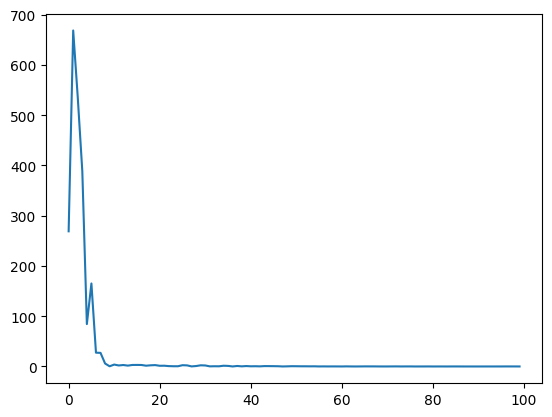

In [199]:
# Visualize the agent's performance
import matplotlib.pyplot as plt

losses_cpu = [loss.cpu().detach().numpy() for loss in losses][:100]
plt.plot(list(range(len(losses_cpu))), losses_cpu)